<a href="https://colab.research.google.com/github/dcolinmorgan/grph/blob/main/single_cell_g_umap_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial: Quick single-cell transcriptomics using GPU UMAP analysis & visualization

Using GPU-accelerated UMAP analysis & visualization, single cell data can be analyzed X% faster and much more easily explored.

* Task: Analyze X for Y
* Data: 5 independent datasets of roughly 30K rows of 200 columns of single cell 
**   [data](https://cytotrace.stanford.edu/#shiny-tab-dataset_download) 
**   [paper](https://arxiv.org/pdf/2208.05229.pdf)
* Sample insight/result: ???


(See also: [CPU baseline](https://colab.research.google.com/drive/1S8E98Fhp0hKvkebBK5AdPxhZcoAKcmOR))

## Setup

(install cuda packages first)

### install

In [ ]:
!pip install --extra-index-url=https://pypi.nvidia.com cuml-cu11==22.10.0 cudf-cu11==22.10.0 cugraph-cu11==22.10.0 pylibraft_cu11==22.10.0 raft_dask_cu11==22.10.0 dask_cudf_cu11==22.10.0 pylibcugraph_cu11==22.10.0 pylibraft_cu11==22.10.0
!pip install graphistry
!pip install scanpy

### import / configure

In [ ]:


import scanpy as sc
import anndata

import graphistry

graphistry.register(api=3,protocol="https", server="hub.graphistry.com", username='dcolinmorgan', password='***') ## key id, secret key
graphistry.__version__


In [4]:
!nvidia-smi

Wed Mar  1 01:40:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !git clone https://github.com/dcolinmorgan/rapidsai-csp-utils/tree/patch-1 
# !python rapidsai-csp-utils/colab/pip-install.py

import cuml
cuml.__version__

# import cupy
# cudf.__version__

'22.10.00a+119.gb30ef85c1'

In [6]:
import os, time
from collections import Counter
import cProfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pstats import Stats
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 200)

## Download Data

In [ ]:
#download 5 single cell datasets
%%bash
wget -nc https://www.dropbox.com/s/xza477kxj7vgdlr/GSE67123_6.h5ad.zip
wget -nc https://www.dropbox.com/s/9r2f3bz4jss9vvr/GSE74767_2.h5ad.zip
wget -nc https://www.dropbox.com/s/thhiv9va2415x6d/GSE97391_27.h5ad.zip
wget -nc https://www.dropbox.com/s/sl76p7hydt40wnv/GSE98664_20.h5ad.zip
wget -nc https://www.dropbox.com/s/i7lyxxa9td2gpmv/GSE97391_22.h5ad.zip
unzip -o GSE67123_6.h5ad.zip
unzip -o GSE74767_2.h5ad.zip
unzip -o GSE97391_27.h5ad.zip
unzip -o GSE98664_20.h5ad.zip
unzip -o GSE97391_22.h5ad.zip

mkdir -p single_cell
mv *.h5ad single_cell

In [8]:

list_files = []
for dirname, _, filenames in os.walk('single_cell'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        list_files.append(os.path.join(dirname, filename))

for fn in list_files:
    adata = sc.read(fn) # sc.read_h5ad
    print( adata.uns['info'] )
    print()

['Blastocyst timepoints (SC3-seq)' 'Validation' '421' 'nan' 'nan' '421'
 '28796' '13' '13' 'TPM/FPKM' 'Macaque' '1' 'Embryo' 'SC3-seq'
 'Timepoints' 'in vivo' '27556940' '20160901' 'GSE74767' 'Nature' 'nan']

['Embryonic HSCs (Tang et al.)' 'Validation' '143' 'nan' 'nan' '143'
 '24028' '5' '5' 'TPM/FPKM' 'Mouse' '1' 'Embryo' 'Tang et al.'
 'Timepoints' 'in vivo' '27225119' '20160526' 'GSE67123' 'Nature' 'nan']

['Direct in vitro neuron (inDrop)' 'Validation' '2684' 'nan' 'nan' '2366'
 '28205' '4' '4' 'UMI' 'Mouse' '1' 'Brain' 'inDrop' 'Phenotypes'
 'in vitro' '28990928' '20171009' 'GSE97391' 'Elife'
 'Cell types involved in neuronal differentiation as highlighted with dashed boundaries in Figure 2 of the original study were assigned ranks based on known differentiation status. ']

['mESC in vitro (RamDA-seq)' 'Validation' '456' 'nan' 'nan' '456' '47515'
 '5' '5' 'TPM/FPKM' 'Mouse' '1' 'Embryo' 'RamDA-seq' 'Timepoints'
 'in vitro' '29434199' '20180212' 'GSE98664' 'Nature Communications'

## scanpy read and compute UMAP for 5 datasets


*   note speed increase



In [9]:
t0 = time.time()

fn='single_cell/GSE67123_6.h5ad'
adata1 = sc.read(fn) # sc.read_h5ad
str_data_inf_1 = fn.split('/')[1].split('.')[0] + ' ' + str(adata1.X.shape)+'\n' + adata1.uns['info'][0]

AA=pd.DataFrame(adata1.X,columns=adata1.uns['gcsGenesNames'],index=adata1.uns['allcellnames'])
g1=graphistry.nodes(AA.reset_index(),"index")#,columns=adata1.uns['gcsGenesNames']))

g11 = g1.umap(
            use_scaler='robust', ## zscale, minmax, standard, normal,
            n_components=2,
            n_neighbors=12,
            engine='cuml'
    )


fn='single_cell/GSE74767_2.h5ad'
adata2 = sc.read(fn) # sc.read_h5ad
str_data_inf_2 = fn.split('/')[1].split('.')[0] + ' ' + str(adata2.X.shape)+'\n' + adata2.uns['info'][0]


BB=pd.DataFrame(adata2.X,index=adata2.uns['allcellnames'])
g2=graphistry.nodes(BB.reset_index(),"index")#,columns=adata2.uns['gcsGenesNames']))

g22 = g2.umap(
            use_scaler='robust', ## zscale, minmax, standard, normal,
            n_components=2,
            n_neighbors=12,
            engine='cuml'
    )

fn='single_cell/GSE97391_27.h5ad'
adata3 = sc.read(fn) # sc.read_h5ad
str_data_inf_3 = fn.split('/')[1].split('.')[0] + ' ' + str(adata3.X.shape)+'\n' + adata3.uns['info'][0]

CC=pd.DataFrame(adata3.X,columns=adata3.uns['gcsGenesNames'],index=adata3.uns['allcellnames'])
g3=graphistry.nodes(CC.reset_index(),"index")#,columns=adata1.uns['gcsGenesNames']))

g33 = g3.umap(
            use_scaler='robust', ## zscale, minmax, standard, normal,
            n_components=2,
            n_neighbors=12,
            engine='cuml'
    )

fn='single_cell/GSE98664_20.h5ad'
adata4 = sc.read(fn) # sc.read_h5ad
str_data_inf_4 = fn.split('/')[1].split('.')[0] + ' ' + str(adata4.X.shape)+'\n' + adata4.uns['info'][0]

DD=pd.DataFrame(adata4.X,columns=adata4.uns['gcsGenesNames'],index=adata4.uns['allcellnames'])
g4=graphistry.nodes(DD.reset_index(),"index")#,columns=adata1.uns['gcsGenesNames']))

g44 = g4.umap(
            use_scaler='robust', ## zscale, minmax, standard, normal,
            n_components=2,
            n_neighbors=12,
            engine='cuml'
    )

fn='single_cell/GSE97391_22.h5ad'
adata5 = sc.read(fn) # sc.read_h5ad
str_data_inf_5 = fn.split('/')[1].split('.')[0] + ' ' + str(adata5.X.shape)+'\n' + adata5.uns['info'][0]

EE=pd.DataFrame(adata5.X,columns=adata5.uns['gcsGenesNames'],index=adata5.uns['allcellnames'])
g5=graphistry.nodes(EE.reset_index(),"index")#,columns=adata1.uns['gcsGenesNames']))

g55 = g5.umap(
            use_scaler='robust', ## zscale, minmax, standard, normal,
            n_components=2,
            n_neighbors=12,
            engine='cuml'
    )

print('Total ', np.round(time.time() - t0,1), 'seconds passed')


Total  149.9 seconds passed


UsageError: Line magic function `%%time` not found.


## Plot cpu tSNE and UMAP v graphistry UMAP

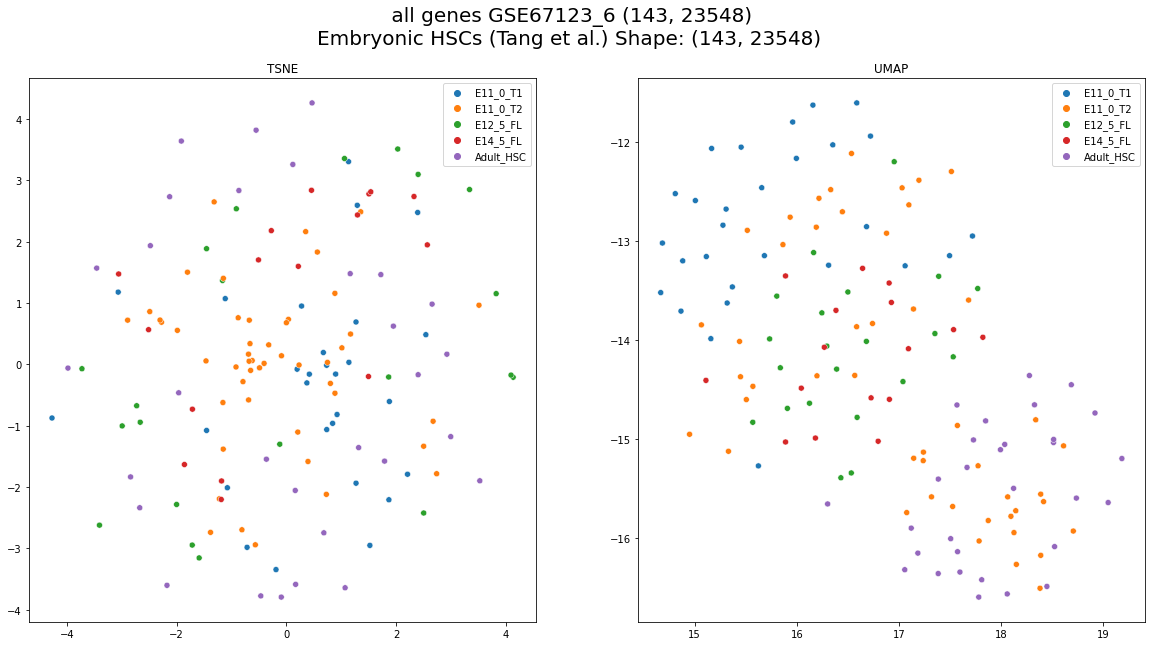

In [13]:
fig,ax = plt.subplots(1,2, figsize = (20,10)); c = 0
ax[0].set_title('TSNE')
ax[1].set_title('UMAP')
plt.suptitle(' all genes ' +str_data_inf_1 + ' Shape: ' + str(adata1.X.shape) , fontsize = 20  )

sns.scatterplot(x = adata1.uns['X_tsne'][:,0], y = adata1.uns['X_tsne'][:,1]  , hue = adata1.uns['Phenotype'],ax=ax[0])

sns.scatterplot(x = adata1.uns['X_umap'][:,0], y = adata1.uns['X_umap'][:,1]  , hue = adata1.uns['Phenotype'],ax=ax[1])

plt.show()

# GSE67123_6 Embryonic HSCs

In [14]:
emb1=g11._node_embedding
g111=graphistry.nodes(emb1.reset_index(),'index').edges(g11._edges,'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})
g111.plot()

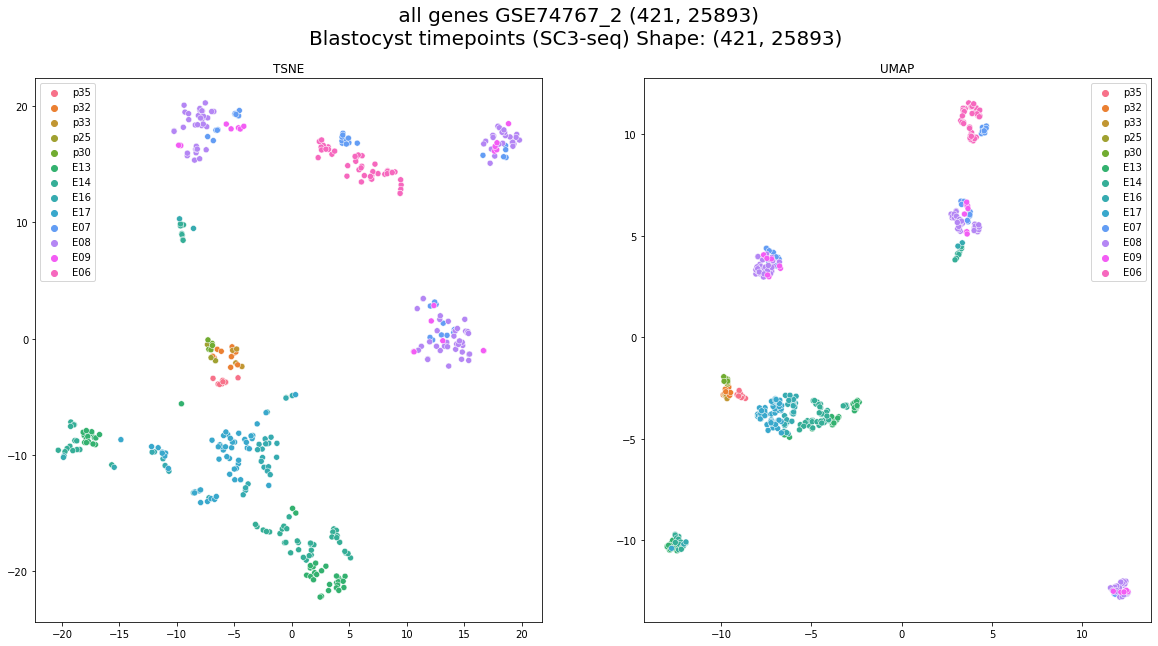

In [15]:
fig,ax = plt.subplots(1,2, figsize = (20,10)); c = 0
ax[0].set_title('TSNE')
ax[1].set_title('UMAP')
plt.suptitle(' all genes ' +str_data_inf_2 + ' Shape: ' + str(adata2.X.shape) , fontsize = 20  )

sns.scatterplot(x = adata2.uns['X_tsne'][:,0], y = adata2.uns['X_tsne'][:,1]  , hue = adata2.uns['Phenotype'],ax=ax[0])

sns.scatterplot(x = adata2.uns['X_umap'][:,0], y = adata2.uns['X_umap'][:,1]  , hue = adata2.uns['Phenotype'],ax=ax[1])

plt.show()

# GSE74767_2 Blastocyst

In [16]:
emb2=g22._node_embedding
g222=graphistry.nodes(emb2.reset_index(),'index').edges(g22._edges,'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})
g222.plot()

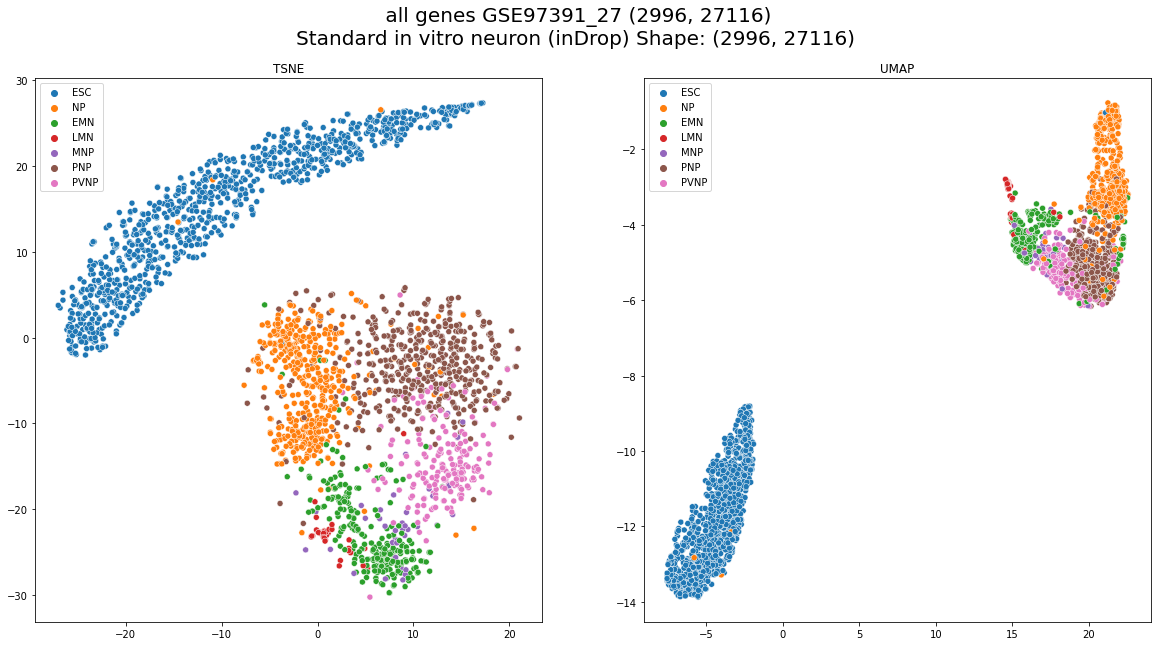

In [17]:
fig,ax = plt.subplots(1,2, figsize = (20,10)); c = 0
ax[0].set_title('TSNE')
ax[1].set_title('UMAP')
plt.suptitle(' all genes ' +str_data_inf_3 + ' Shape: ' + str(adata3.X.shape) , fontsize = 20  )

sns.scatterplot(x = adata3.uns['X_tsne'][:,0], y = adata3.uns['X_tsne'][:,1]  , hue = adata3.uns['Phenotype'],ax=ax[0])

sns.scatterplot(x = adata3.uns['X_umap'][:,0], y = adata3.uns['X_umap'][:,1]  , hue = adata3.uns['Phenotype'],ax=ax[1])

plt.show()

# GSE97391_27 Neuronal

In [18]:
emb3=g33._node_embedding
g333=graphistry.nodes(emb3.reset_index(),'index').edges(g33._edges,'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})
g333.plot()

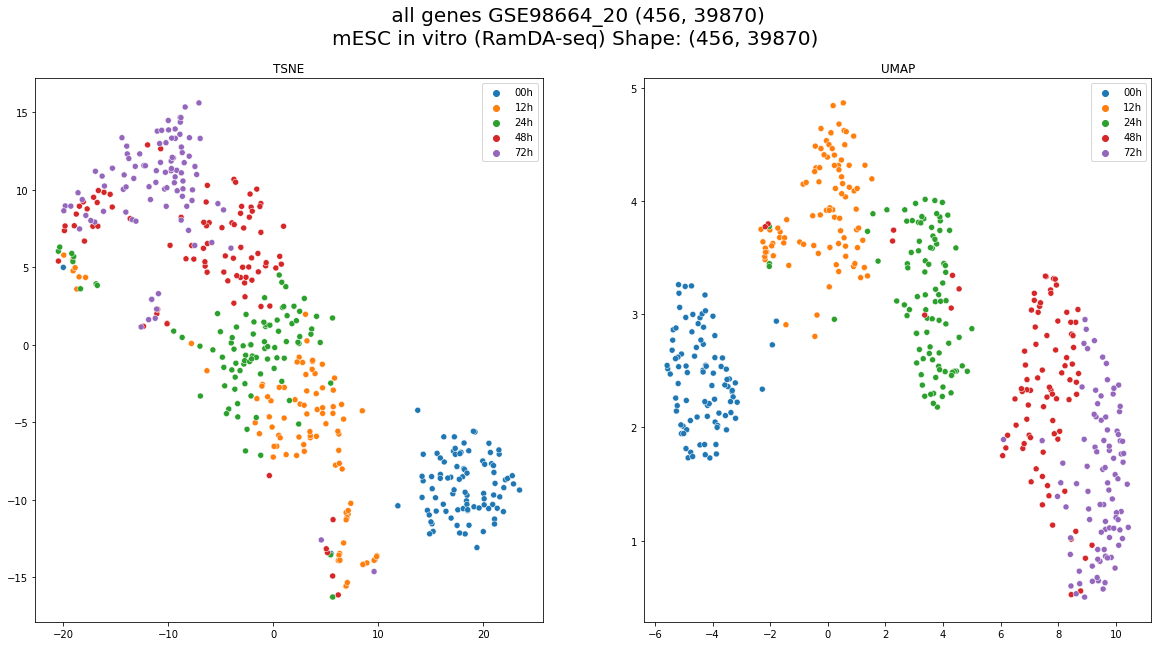

In [19]:
fig,ax = plt.subplots(1,2, figsize = (20,10)); c = 0
ax[0].set_title('TSNE')
ax[1].set_title('UMAP')
plt.suptitle(' all genes ' +str_data_inf_4 + ' Shape: ' + str(adata4.X.shape) , fontsize = 20  )

sns.scatterplot(x = adata4.uns['X_tsne'][:,0], y = adata4.uns['X_tsne'][:,1]  , hue = adata4.uns['Phenotype'],ax=ax[0])

sns.scatterplot(x = adata4.uns['X_umap'][:,0], y = adata4.uns['X_umap'][:,1]  , hue = adata4.uns['Phenotype'],ax=ax[1])

plt.show()

# GSE98664_20 mESC

In [20]:
emb4=g44._node_embedding
g444=graphistry.nodes(emb4.reset_index(),'index').edges(g44._edges,'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})
g444.plot()

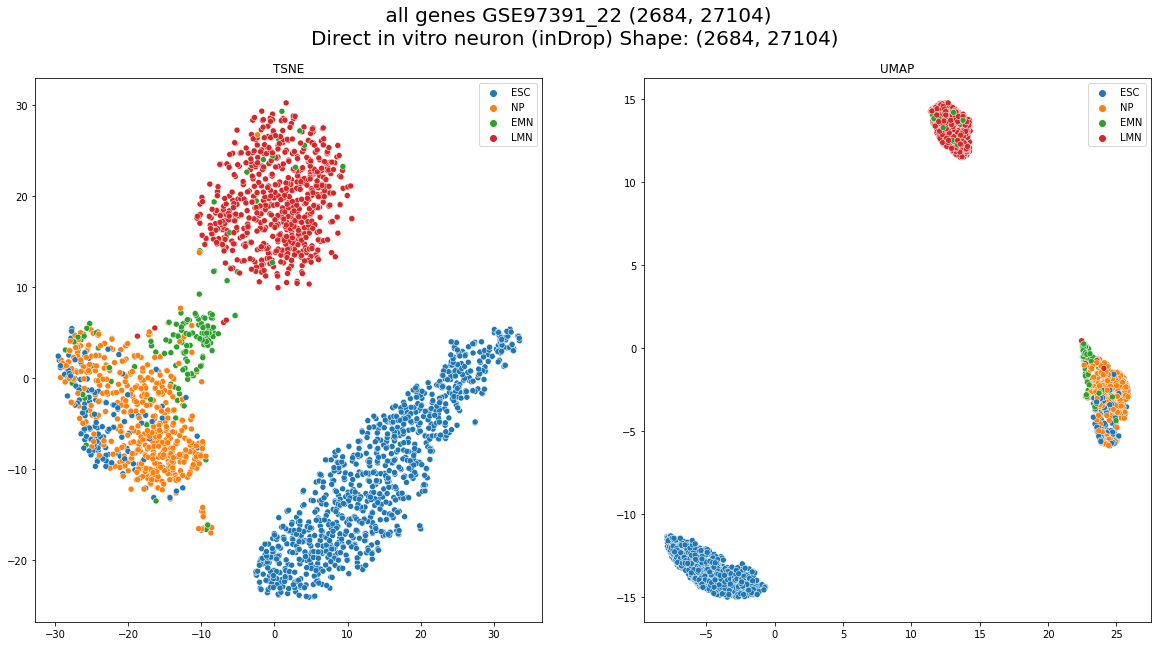

In [21]:
fig,ax = plt.subplots(1,2, figsize = (20,10)); c = 0
ax[0].set_title('TSNE')
ax[1].set_title('UMAP')
plt.suptitle(' all genes ' +str_data_inf_5 + ' Shape: ' + str(adata5.X.shape) , fontsize = 20  )

sns.scatterplot(x = adata5.uns['X_tsne'][:,0], y = adata5.uns['X_tsne'][:,1]  , hue = adata5.uns['Phenotype'],ax=ax[0])

sns.scatterplot(x = adata5.uns['X_umap'][:,0], y = adata5.uns['X_umap'][:,1]  , hue = adata5.uns['Phenotype'],ax=ax[1])

plt.show()

# GSE97391_22 Neuronal

In [22]:
emb5=g55._node_embedding
g555=graphistry.nodes(emb5.reset_index(),'index').edges(g55._edges,'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})
g555.plot()